# LUCID-GAN COMPAS

In [1]:
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from cycler import cycler

import numpy as np
import pandas as pd
import tensorflow as tf

from canonical_sets import LUCID, LUCIDGAN
from canonical_sets.data import Compas
from canonical_sets.models import ClassifierTF
from canonical_sets.group import Metrics

In [2]:
# Potential Direct Discrimination (protected attributes included)
tf.keras.utils.set_random_seed(42)

callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)

compas = Compas()
dir_compas_model = ClassifierTF(2)
dir_compas_model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])
dir_compas_model.fit(compas.train_data.to_numpy(), compas.train_labels.to_numpy(), epochs=200,
 validation_data=(compas.val_data.to_numpy(), compas.val_labels.to_numpy()),
 callbacks=[callback], verbose=0)
print(f"Test accuracy: {dir_compas_model.evaluate(compas.test_data.to_numpy(), compas.test_labels.to_numpy())[1]}")

39/39 [==============================] - 0s 2ms/step - loss: 0.6421 - accuracy: 0.6397
Test accuracy: 0.6396760940551758


In [3]:
# Output-based metrics
compas_preds = dir_compas_model.predict(compas.test_data.to_numpy())
compas_test_data = compas.inverse_preprocess(compas.test_data)

protected_attribute = "race"

for i in compas_test_data[protected_attribute].unique().tolist():
    metrics = Metrics(compas.test_labels[compas_test_data[protected_attribute] == i][0], compas_preds[compas_test_data[protected_attribute] == i].argmax(axis=1))
    print(i)
    print(metrics.metrics)

39/39 [==============================] - 0s 1ms/step
Hispanic
{'acc': 38.4, 'pr': 62.5, 'tpr': 52.0}
African-American
{'acc': 36.1, 'pr': 49.2, 'tpr': 37.6}
Caucasian
{'acc': 34.2, 'pr': 61.9, 'tpr': 41.9}
Other
{'acc': 42.9, 'pr': 54.0, 'tpr': 25.0}
Native American
{'acc': 60.0, 'pr': 60.0, 'tpr': 60.0}
Asian
{'acc': 28.6, 'pr': 71.4, 'tpr': nan}


C:\Users\andre\Dropbox\AI\github\canonical_sets\canonical_sets\group.py:59: RuntimeWarning: invalid value encountered in scalar divide
  "tpr": np.around(tp / (tp + fn) * 100, 1),


In [4]:
# LUCID
compas_outputs = pd.DataFrame([[1, 0]], columns=["No-Recid", "Recid"])

compas_lucid = LUCID(dir_compas_model, compas_outputs, compas.train_data,
                    one_hot_post=False, extra_epoch=False, numb_of_samples=1000)
compas_lucid.process_results(compas.scaler)

100%|██████████| 1000/1000 [23:43<00:00,  1.42s/it]


39/39 [==============================] - 0s 1ms/step


Epoch 299, Loss G: -0.6322, Loss R:  0.0380, Loss D:  0.0037: 100%|██████████| 300/300 [00:37<00:00,  8.04it/s]


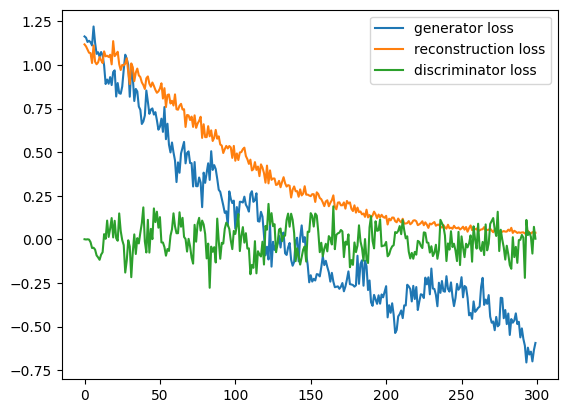

In [5]:
# LUCID-GAN
compas_preds = dir_compas_model.predict(compas.test_data.to_numpy())[:, 0]
compas_test_data = compas.inverse_preprocess(compas.test_data)
compas_data = pd.concat([compas_test_data, pd.DataFrame(compas_preds, columns=["preds"])], axis=1)

dir_compas_lucidgan = LUCIDGAN(epochs=300)

dir_compas_lucidgan.set_random_state(1234)
dir_compas_lucidgan.fit(compas_data, conditional=["preds"])

dir_compas_pos_samples = dir_compas_lucidgan.sample(1000, conditional=pd.DataFrame({"preds": [1]}))
dir_compas_neg_samples = dir_compas_lucidgan.sample(1000, conditional=pd.DataFrame({"preds": [0]}))

plt.plot(dir_compas_lucidgan.generator_loss, label = "generator loss")
plt.plot(dir_compas_lucidgan.reconstruction_loss, label = "reconstruction loss")
plt.plot(dir_compas_lucidgan.discriminator_loss, label = "discriminator loss")
plt.legend()
plt.show()

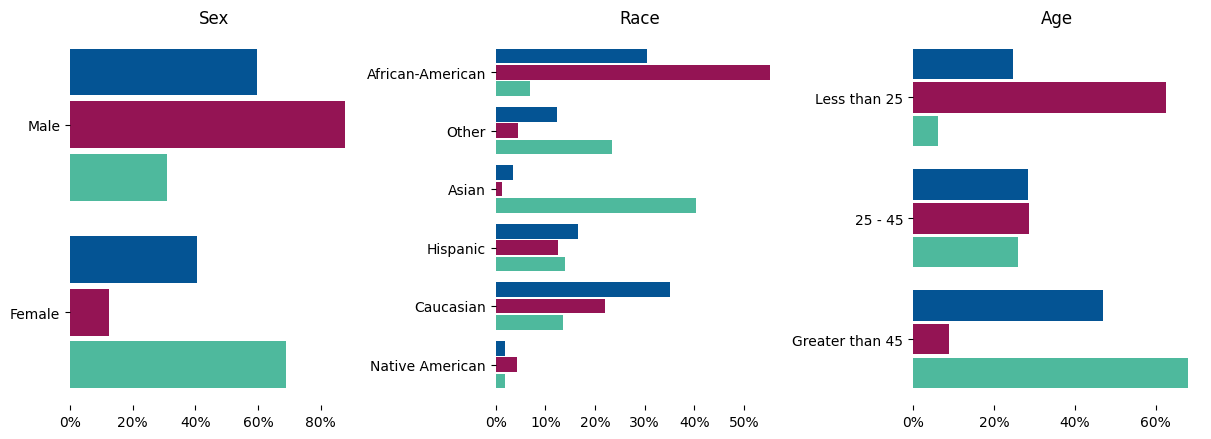

In [6]:
rcParams['axes.prop_cycle'] = cycler('color', ['#045494', '#941454', '#4eb99d'])

# Figure compas: LUCID vs LUCID-GAN
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
spec = fig.add_gridspec(6, 3)
width = 0.25

# Fig 1
ax1 = fig.add_subplot(spec[0:3, 0:1])
ax1.set_title('Sex')
labels=['Male','Female']
x = np.arange(len(labels))

lucid_sex_count = compas_lucid.results_processed.query("epoch == 200").sex.value_counts()
lucidgan_sex_count = dir_compas_pos_samples.sex.value_counts()
lucidgan_sex_count_neg = dir_compas_neg_samples.sex.value_counts()

missing = lucid_sex_count.index[~lucid_sex_count.index.isin(lucidgan_sex_count.index)].to_list()
for i in missing:
    lucidgan_sex_count[i] = 0

missing = lucid_sex_count.index[~lucid_sex_count.index.isin(lucidgan_sex_count_neg.index)].to_list()
for i in missing:
    lucidgan_sex_count_neg[i] = 0

ax1.barh(x - width-0.03, [lucidgan_sex_count["Male"], lucidgan_sex_count["Female"]], width, label='LUCID-GAN')
ax1.barh(x, [lucidgan_sex_count_neg["Male"], lucidgan_sex_count_neg["Female"]], width, label='LUCID-GAN')
ax1.barh(x + width+0.03, [lucid_sex_count["Male"], lucid_sex_count["Female"]], width, label='LUCID')

ax1.set_yticks(x)
ax1.set_yticklabels(labels)
ax1.invert_yaxis()
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 2
ax2 = fig.add_subplot(spec[0:3,1:2])
ax2.set_title('Race')
labels=['African-American', 'Other', 'Asian', 'Hispanic', 'Caucasian', 'Native American']
x = np.arange(len(labels))

lucid_race_count = compas_lucid.results_processed.query("epoch == 200").race.value_counts()
lucidgan_race_count = dir_compas_pos_samples.race.value_counts()
lucidgan_race_count_neg = dir_compas_neg_samples.race.value_counts()

missing = lucid_race_count.index[~lucid_race_count.index.isin(lucidgan_race_count.index)].to_list()
for i in missing:
    lucidgan_race_count[i] = 0

missing = lucid_race_count.index[~lucid_race_count.index.isin(lucidgan_race_count_neg.index)].to_list()
for i in missing:
    lucidgan_race_count_neg[i] = 0

ax2.barh(x - width-0.03, [lucidgan_race_count["African-American"], lucidgan_race_count["Other"],
                            lucidgan_race_count["Asian"], lucidgan_race_count["Hispanic"],
                            lucidgan_race_count["Caucasian"], lucidgan_race_count["Native American"]], width, label='LUCID-GAN')
ax2.barh(x, [lucidgan_race_count_neg["African-American"], lucidgan_race_count_neg["Other"],
                            lucidgan_race_count_neg["Asian"], lucidgan_race_count_neg["Hispanic"],
                            lucidgan_race_count_neg["Caucasian"], lucidgan_race_count_neg["Native American"]], width, label='LUCID-GAN')
ax2.barh(x + width+0.03, [lucid_race_count["African-American"], lucid_race_count["Other"],
                            lucid_race_count["Asian"], lucid_race_count["Hispanic"],
                            lucid_race_count["Caucasian"], lucidgan_race_count["Native American"]], width, label='LUCID')

ax2.set_yticks(x)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()

ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)


# Fig 3
ax3 = fig.add_subplot(spec[0:3,-1])
ax3.set_title('Age')
labels=['Less than 25', '25 - 45', 'Greater than 45']
x = np.arange(len(labels))

lucid_age_count = compas_lucid.results_processed.query("epoch == 200").age_cat.value_counts()
lucidgan_age_count = dir_compas_pos_samples.age_cat.value_counts()
lucidgan_age_count_neg = dir_compas_neg_samples.age_cat.value_counts()

missing = lucid_age_count.index[~lucid_age_count.index.isin(lucidgan_age_count.index)].to_list()
for i in missing:
    lucidgan_age_count[i] = 0

missing = lucid_age_count.index[~lucid_age_count.index.isin(lucidgan_age_count_neg.index)].to_list()
for i in missing:
    lucidgan_age_count_neg[i] = 0

ax3.barh(x - width-0.03, [lucidgan_age_count["Less than 25"], lucidgan_age_count["25 - 45"],
                            lucidgan_age_count["Greater than 45"]], width, label='LUCID-GAN')
ax3.barh(x, [lucidgan_age_count_neg["Less than 25"], lucidgan_age_count_neg["25 - 45"],
                            lucidgan_age_count_neg["Greater than 45"]], width, label='LUCID-GAN')
ax3.barh(x + width+0.03, [lucid_age_count["Less than 25"], lucid_age_count["25 - 45"],
                            lucid_age_count["Greater than 45"]], width, label='LUCID')

ax3.set_yticks(x)
ax3.set_yticklabels(labels)
ax3.invert_yaxis()

ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

plt.savefig("direct_discrimination_compas.pdf", format="pdf", bbox_inches='tight')

In [7]:
# Potential Indirect Discrimination (protected attributes excluded)
tf.keras.utils.set_random_seed(42)

callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)

compas = Compas()

protected_attributes = compas.train_data.columns[compas.train_data.columns.str.startswith(("sex", "race"))].to_list()
test_protected = compas._inverse_ohe(compas.test_data)[["sex", "race"]]

compas.train_data.drop(protected_attributes, axis=1, inplace=True)
compas.val_data.drop(protected_attributes, axis=1, inplace=True)
compas.test_data.drop(protected_attributes, axis=1, inplace=True)

ind_compas_model = ClassifierTF(2)
ind_compas_model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])
ind_compas_model.fit(compas.train_data.to_numpy(), compas.train_labels.to_numpy(), epochs=200,
 validation_data=(compas.val_data.to_numpy(), compas.val_labels.to_numpy()),
 callbacks=[callback], verbose=0)
print(f"Test accuracy: {ind_compas_model.evaluate(compas.test_data.to_numpy(), compas.test_labels.to_numpy())[1]}")

39/39 [==============================] - 0s 1ms/step - loss: 0.6384 - accuracy: 0.6470
Test accuracy: 0.6469635367393494


In [8]:
# Output-based metrics
protected_attribute = "sex"

compas_preds = ind_compas_model.predict(compas.test_data.to_numpy())
compas_test_data = compas.inverse_preprocess(compas.test_data)

for i in test_protected[protected_attribute].unique().tolist():
    metrics = Metrics(compas.test_labels[test_protected[protected_attribute] == i][0], compas_preds[test_protected[protected_attribute] == i].argmax(axis=1))
    print(i)
    print(metrics.metrics)

39/39 [==============================] - 0s 882us/step
Male
{'acc': 35.7, 'pr': 53.6, 'tpr': 35.6}
Female
{'acc': 33.8, 'pr': 62.7, 'tpr': 42.6}


39/39 [==============================] - 0s 961us/step


Epoch 299, Loss G: -0.3500, Loss R:  0.0324, Loss D: -0.0489: 100%|██████████| 300/300 [00:47<00:00,  6.28it/s]


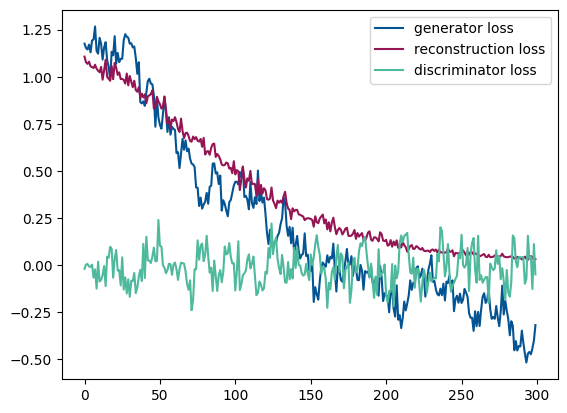

In [9]:
# LUCID-GAN with the inclusion of the protected attributes
compas_preds = ind_compas_model.predict(compas.test_data.to_numpy())[:, 0]
compas_test_data = compas.inverse_preprocess(compas.test_data)

compas_data = pd.concat([compas_test_data, test_protected, pd.DataFrame(compas_preds, columns=["preds"])], axis=1)

ind_compas_lucidgan = LUCIDGAN(epochs=300)

ind_compas_lucidgan.set_random_state(1234)
ind_compas_lucidgan.fit(compas_data, conditional=["preds"])

ind_compas_pos_samples = ind_compas_lucidgan.sample(1000, conditional=pd.DataFrame({"preds": [1]}))
ind_compas_neg_samples = ind_compas_lucidgan.sample(1000, conditional=pd.DataFrame({"preds": [0]}))

plt.plot(ind_compas_lucidgan.generator_loss, label = "generator loss")
plt.plot(ind_compas_lucidgan.reconstruction_loss, label = "reconstruction loss")
plt.plot(ind_compas_lucidgan.discriminator_loss, label = "discriminator loss")
plt.legend()
plt.show()

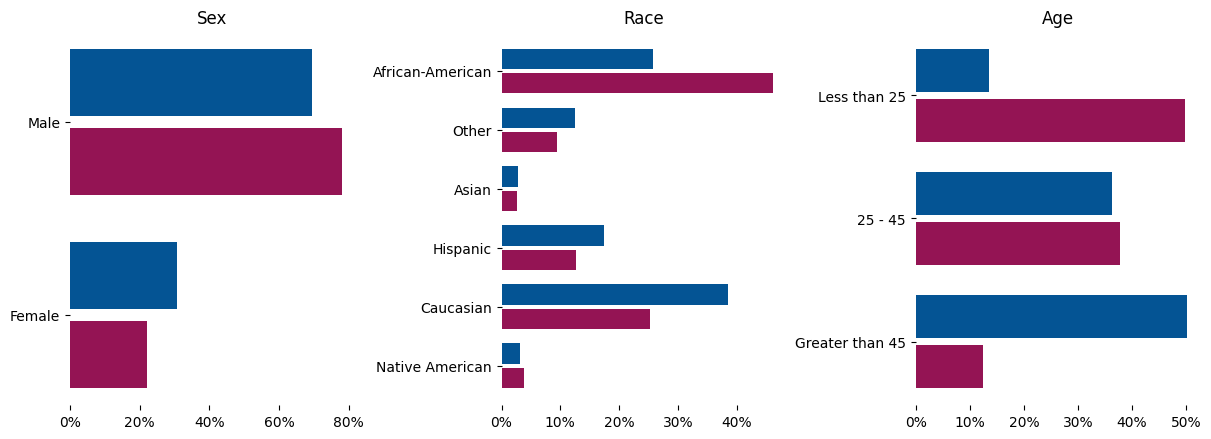

In [10]:
rcParams['axes.prop_cycle'] = cycler('color', ['#045494', '#941454'])

# Figure COMPAS
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
spec = fig.add_gridspec(6, 3)
width = 0.35

# Fig 1
ax1 = fig.add_subplot(spec[0:3, 0:1])
ax1.set_title('Sex')
labels=['Male','Female']
x = np.arange(len(labels))

lucidgan_sex_count = ind_compas_pos_samples.sex.value_counts()
lucidgan_sex_count_neg = ind_compas_neg_samples.sex.value_counts()

for i in compas_data["sex"].unique()[[i not in lucidgan_sex_count for i in compas_data["sex"].unique()]]:
    lucidgan_sex_count[i] = 0

for i in compas_data["sex"].unique()[[i not in lucidgan_sex_count_neg for i in compas_data["sex"].unique()]]:
    lucidgan_sex_count_neg[i] = 0

ax1.barh(x - width/2-0.03, [lucidgan_sex_count["Male"], lucidgan_sex_count["Female"]], width, label='LUCID-GAN')
ax1.barh(x + width/2+0.03, [lucidgan_sex_count_neg["Male"], lucidgan_sex_count_neg["Female"]], width, label='LUCID-GAN')

ax1.set_yticks(x)
ax1.set_yticklabels(labels)
ax1.invert_yaxis()
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 2
ax2 = fig.add_subplot(spec[0:3,1:2])
ax2.set_title('Race')
labels=['African-American', 'Other', 'Asian', 'Hispanic', 'Caucasian', 'Native American']
x = np.arange(len(labels))

lucidgan_race_count = ind_compas_pos_samples.race.value_counts()
lucidgan_race_count_neg = ind_compas_neg_samples.race.value_counts()

for i in compas_data["race"].unique()[[i not in lucidgan_race_count for i in compas_data["race"].unique()]]:
    lucidgan_race_count[i] = 0

for i in compas_data["race"].unique()[[i not in lucidgan_race_count_neg for i in compas_data["race"].unique()]]:
    lucidgan_race_count_neg[i] = 0

ax2.barh(x - width/2-0.03, [lucidgan_race_count["African-American"], lucidgan_race_count["Other"],
                            lucidgan_race_count["Asian"], lucidgan_race_count["Hispanic"],
                            lucidgan_race_count["Caucasian"], lucidgan_race_count["Native American"]], width, label='LUCID-GAN')
ax2.barh(x + width/2+0.03, [lucidgan_race_count_neg["African-American"], lucidgan_race_count_neg["Other"],
                            lucidgan_race_count_neg["Asian"], lucidgan_race_count_neg["Hispanic"],
                            lucidgan_race_count_neg["Caucasian"], lucidgan_race_count_neg["Native American"]], width, label='LUCID')

ax2.set_yticks(x)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()

ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 3
ax3 = fig.add_subplot(spec[0:3,-1])
ax3.set_title('Age')
labels=['Less than 25', '25 - 45', 'Greater than 45']
x = np.arange(len(labels))

lucidgan_age_count = ind_compas_pos_samples.age_cat.value_counts()
lucidgan_age_count_neg = ind_compas_neg_samples.age_cat.value_counts()

for i in compas_data["age_cat"].unique()[[i not in lucidgan_age_count for i in compas_data["age_cat"].unique()]]:
    lucidgan_age_count[i] = 0

for i in compas_data["age_cat"].unique()[[i not in lucidgan_age_count_neg for i in compas_data["age_cat"].unique()]]:
    lucidgan_age_count_neg[i] = 0

ax3.barh(x - width/2-0.03, [lucidgan_age_count["Less than 25"], lucidgan_age_count["25 - 45"],
                            lucidgan_age_count["Greater than 45"]], width, label='LUCID-GAN')
ax3.barh(x + width/2+0.03, [lucidgan_age_count_neg["Less than 25"], lucidgan_age_count_neg["25 - 45"],
                            lucidgan_age_count_neg["Greater than 45"]], width, label='LUCID')

ax3.set_yticks(x)
ax3.set_yticklabels(labels)
ax3.invert_yaxis()

ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

plt.savefig("indirect_discrimination_compas_pos_neg.pdf", format="pdf", bbox_inches='tight')

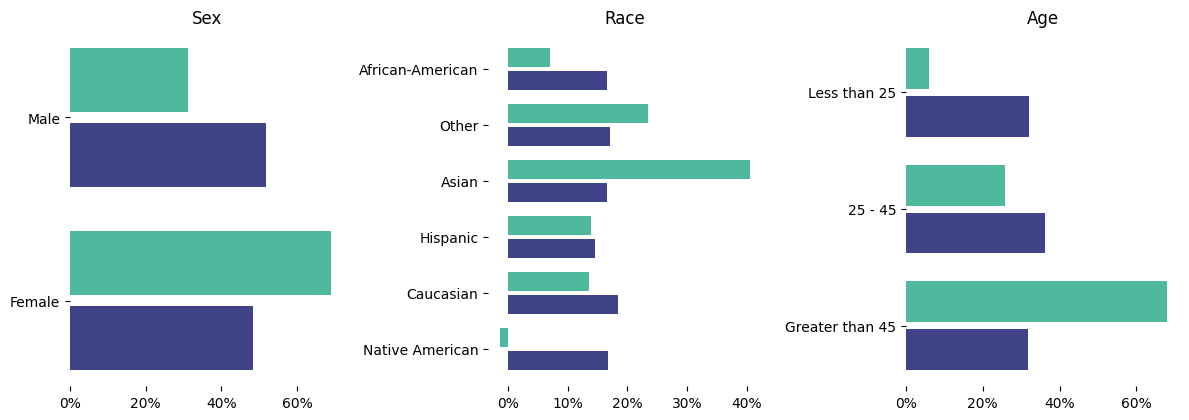

In [16]:
rcParams['axes.prop_cycle'] = cycler('color', ['#4eb99d', '#404387'])

# LUCID vs Uniform
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
spec = fig.add_gridspec(6, 3)
width = 0.35

# Fig 1
ax1 = fig.add_subplot(spec[0:3, 0:1])
ax1.set_title('Sex')
labels=['Male','Female']
x = np.arange(len(labels))

lucidint_sex_count = compas_lucid.results_processed.query("epoch == 1").sex.value_counts()
lucid_sex_count = compas_lucid.results_processed.query("epoch == 200").sex.value_counts()

ax1.barh(x - width/2-0.03, [lucid_sex_count["Male"], lucid_sex_count["Female"]], width, label='LUCID')
ax1.barh(x + width/2+0.03, [lucidint_sex_count["Male"], lucidint_sex_count["Female"]], width, label='LUCID')

ax1.set_yticks(x)
ax1.set_yticklabels(labels)
ax1.invert_yaxis()
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 2
ax2 = fig.add_subplot(spec[0:3,1:2])
ax2.set_title('Race')
labels=['African-American', 'Other', 'Asian', 'Hispanic', 'Caucasian', 'Native American']
x = np.arange(len(labels))

lucidint_race_count = compas_lucid.results_processed.query("epoch == 1").race.value_counts()
lucid_race_count = compas_lucid.results_processed.query("epoch == 200").race.value_counts()

ax2.barh(x - width/2-0.03, [lucid_race_count["African-American"], lucid_race_count["Other"],
                            lucid_race_count["Asian"], lucid_race_count["Hispanic"],
                            lucid_race_count["Caucasian"], lucidgan_race_count["Native American"]], width, label='LUCID')
ax2.barh(x + width/2+0.03, [lucidint_race_count["African-American"], lucidint_race_count["Other"],
                            lucidint_race_count["Asian"], lucidint_race_count["Hispanic"],
                            lucidint_race_count["Caucasian"], lucidint_race_count["Native American"]], width, label='LUCID')

ax2.set_yticks(x)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()

ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 3
ax3 = fig.add_subplot(spec[0:3,-1])
ax3.set_title('Age')
labels=['Less than 25', '25 - 45', 'Greater than 45']
x = np.arange(len(labels))

lucidint_age_count = compas_lucid.results_processed.query("epoch == 1").age_cat.value_counts()
lucid_age_count = compas_lucid.results_processed.query("epoch == 200").age_cat.value_counts()

ax3.barh(x - width/2-0.03, [lucid_age_count["Less than 25"], lucid_age_count["25 - 45"],
                            lucid_age_count["Greater than 45"]], width, label='LUCID')
ax3.barh(x + width/2+0.03, [lucidint_age_count["Less than 25"], lucidint_age_count["25 - 45"],
                            lucidint_age_count["Greater than 45"]], width, label='LUCID')

ax3.set_yticks(x)
ax3.set_yticklabels(labels)
ax3.invert_yaxis()

ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

plt.savefig("lucid_compas.pdf", format="pdf", bbox_inches='tight')

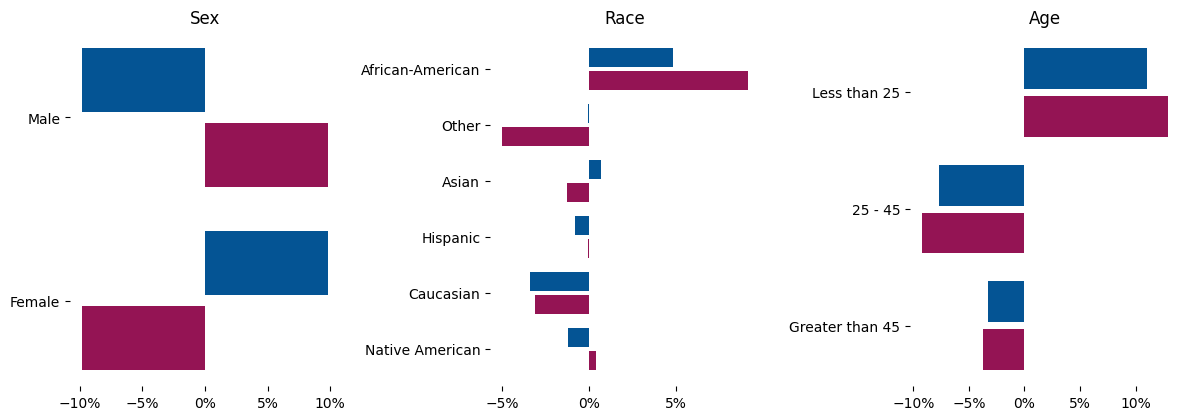

In [17]:
rcParams['axes.prop_cycle'] = cycler('color', ['#045494', '#941454'])

# Differences direct vs indirect discrimination
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
spec = fig.add_gridspec(6, 3)
width = 0.35

# Fig 1
ax1 = fig.add_subplot(spec[0:3, 0:1])
ax1.set_title('Sex')
labels=['Male','Female']
x = np.arange(len(labels))

lucidgan_sex_count = dir_compas_pos_samples.sex.value_counts().sort_index() - ind_compas_pos_samples.sex.value_counts().sort_index()
lucidgan_sex_count_neg = dir_compas_neg_samples.sex.value_counts().sort_index() - ind_compas_neg_samples.sex.value_counts().sort_index()

ax1.barh(x - width/2-0.03, [lucidgan_sex_count["Male"], lucidgan_sex_count["Female"]], width, label='LUCID-GAN')
ax1.barh(x + width/2+0.03, [lucidgan_sex_count_neg["Male"], lucidgan_sex_count_neg["Female"]], width, label='LUCID-GAN')

ax1.set_yticks(x)
ax1.set_yticklabels(labels)
ax1.invert_yaxis()
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 2
ax2 = fig.add_subplot(spec[0:3,1:2])
ax2.set_title('Race')
labels=['African-American', 'Other', 'Asian', 'Hispanic', 'Caucasian', 'Native American']
x = np.arange(len(labels))

lucidgan_race_count = dir_compas_pos_samples.race.value_counts().sort_index() - ind_compas_pos_samples.race.value_counts().sort_index()
lucidgan_race_count_neg = dir_compas_neg_samples.race.value_counts().sort_index() - ind_compas_neg_samples.race.value_counts().sort_index()

for i in compas_data["race"].unique()[[i not in lucidgan_race_count for i in compas_data["race"].unique()]]:
    lucidgan_race_count[i] = 0

for i in compas_data["race"].unique()[[i not in lucidgan_race_count_neg for i in compas_data["race"].unique()]]:
    lucidgan_race_count_neg[i] = 0

ax2.barh(x - width/2-0.03, [lucidgan_race_count["African-American"], lucidgan_race_count["Other"],
                            lucidgan_race_count["Asian"], lucidgan_race_count["Hispanic"],
                            lucidgan_race_count["Caucasian"], lucidgan_race_count["Native American"]], width, label='LUCID-GAN')
ax2.barh(x + width/2+0.03, [lucidgan_race_count_neg["African-American"], lucidgan_race_count_neg["Other"],
                            lucidgan_race_count_neg["Asian"], lucidgan_race_count_neg["Hispanic"],
                            lucidgan_race_count_neg["Caucasian"], lucidgan_race_count_neg["Native American"]], width, label='LUCID')

ax2.set_yticks(x)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()

ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 3
ax3 = fig.add_subplot(spec[0:3,-1])
ax3.set_title('Age')
labels=['Less than 25', '25 - 45', 'Greater than 45']
x = np.arange(len(labels))

lucidgan_age_count = dir_compas_pos_samples.age_cat.value_counts().sort_index() - ind_compas_pos_samples.age_cat.value_counts().sort_index()
lucidgan_age_count_neg = dir_compas_neg_samples.age_cat.value_counts().sort_index() - ind_compas_neg_samples.age_cat.value_counts().sort_index()

for i in compas_data["age_cat"].unique()[[i not in lucidgan_age_count for i in compas_data["age_cat"].unique()]]:
    lucidgan_age_count[i] = 0

for i in compas_data["age_cat"].unique()[[i not in lucidgan_age_count_neg for i in compas_data["age_cat"].unique()]]:
    lucidgan_age_count_neg[i] = 0

ax3.barh(x - width/2-0.03, [lucidgan_age_count["Less than 25"], lucidgan_age_count["25 - 45"],
                            lucidgan_age_count["Greater than 45"]], width, label='LUCID-GAN')
ax3.barh(x + width/2+0.03, [lucidgan_age_count_neg["Less than 25"], lucidgan_age_count_neg["25 - 45"],
                            lucidgan_age_count_neg["Greater than 45"]], width, label='LUCID')

ax3.set_yticks(x)
ax3.set_yticklabels(labels)
ax3.invert_yaxis()

ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

plt.savefig("compare_compas.pdf", format="pdf", bbox_inches='tight')

In [13]:
# Intersectional Discrimination in COMPAS
tf.keras.utils.set_random_seed(42)

callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)

compas = Compas()
compas_model = ClassifierTF(2)
compas_model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])
compas_model.fit(compas.train_data.to_numpy(), compas.train_labels.to_numpy(), epochs=200,
 validation_data=(compas.val_data.to_numpy(), compas.val_labels.to_numpy()),
 callbacks=[callback], verbose=0)
print(f"Test accuracy: {compas_model.evaluate(compas.test_data.to_numpy(), compas.test_labels.to_numpy())[1]}")

39/39 [==============================] - 0s 1ms/step - loss: 0.6421 - accuracy: 0.6397
Test accuracy: 0.6396760940551758


39/39 [==============================] - 0s 1ms/step


Epoch 299, Loss G: -0.6322, Loss R:  0.0380, Loss D:  0.0037: 100%|██████████| 300/300 [00:28<00:00, 10.42it/s]


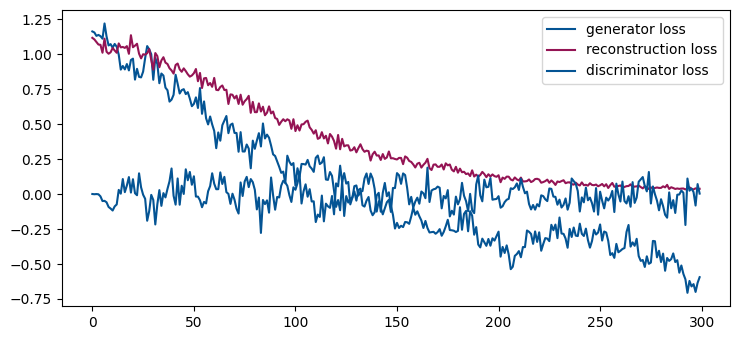

In [20]:
compas_preds = compas_model.predict(compas.test_data.to_numpy())[:, 0] # take positive predictions
compas_test_data = compas.inverse_preprocess(compas.test_data)
compas_data = pd.concat([compas_test_data, pd.DataFrame(compas_preds, columns=["preds"])], axis=1)

int_compas_lucidgan = LUCIDGAN(epochs=300)

int_compas_lucidgan.set_random_state(1234)
int_compas_lucidgan.fit(compas_data, conditional=["preds"])

plt.plot(int_compas_lucidgan.generator_loss, label = "generator loss")
plt.plot(int_compas_lucidgan.reconstruction_loss, label = "reconstruction loss")
plt.plot(int_compas_lucidgan.discriminator_loss, label = "discriminator loss")
plt.legend()
plt.show()

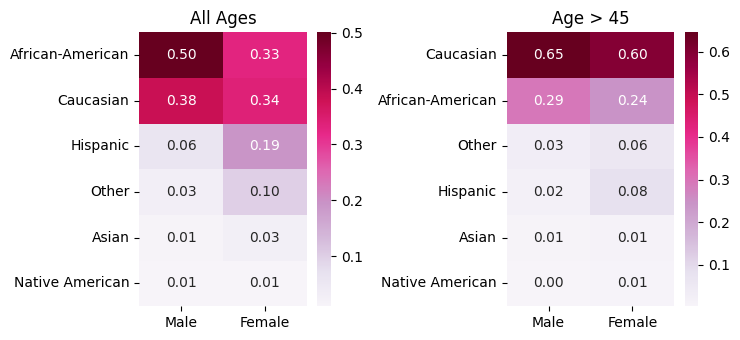

In [21]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=5.51)

int_compas_male_samples = int_compas_lucidgan.sample(1000, condition_column=["sex"], condition_value=["Male"], conditional=pd.DataFrame({"preds": [1]}))
int_compas_female_samples = int_compas_lucidgan.sample(1000, condition_column=["sex"], condition_value=["Female"], conditional=pd.DataFrame({"preds": [1]}))

int_compas_male_samples = int_compas_male_samples.race.value_counts(normalize=True)
int_compas_female_samples = int_compas_female_samples.race.value_counts(normalize=True)

int_compas_sex_samples = pd.concat([int_compas_male_samples, int_compas_female_samples], axis=1).fillna(0)
int_compas_sex_samples.columns = ["Male", "Female"]

sns.heatmap(int_compas_sex_samples, cmap="PuRd", shading='auto', annot=True, fmt=".2f", ax=ax1)
ax1.set_title("All Ages")

int_compas_male_samples = int_compas_lucidgan.sample(1000, condition_column=["sex", "age_cat"], condition_value=["Male", "Greater than 45"], conditional=pd.DataFrame({"preds": [1]}))
int_compas_female_samples = int_compas_lucidgan.sample(1000, condition_column=["sex", "age_cat"], condition_value=["Female", "Greater than 45"], conditional=pd.DataFrame({"preds": [1]}))

int_compas_male_samples = int_compas_male_samples.race.value_counts(normalize=True)
int_compas_female_samples = int_compas_female_samples.race.value_counts(normalize=True)

int_compas_sex_samples = pd.concat([int_compas_male_samples, int_compas_female_samples], axis=1).fillna(0)
int_compas_sex_samples.columns = ["Male", "Female"]

sns.heatmap(int_compas_sex_samples, cmap="PuRd", shading='auto', annot=True, fmt=".2f", ax=ax2)
ax2.set_title("Age > 45")

plt.savefig("intersectional_compas.pdf", format="pdf", bbox_inches='tight')